# XGBoost HYPEROPT VS XGBoost VS SVR PRICE REGRESSION

In [336]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [337]:
df=pd.read_csv('audi.csv',skipinitialspace=True)

During the model deployment, I noticed that the values in the model columns had a blank space in front. For this reason, I decided to add "skipinitialspace=True" during the creation of the dataframe.

In [338]:
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0


I will reorder the columns to group the categorical variables first and then the numerical ones

In [339]:
df=df[['model','year','transmission','fuelType','mileage','tax','mpg','engineSize','price']]

In [383]:
df.head(10)

,model,year,transmission,fuelType,mileage,tax,mpg,engineSize,price
0,A1,2017,Manual,Petrol,15735,150,55.4,1.4,12500
1,A6,2016,Automatic,Diesel,36203,20,64.2,2.0,16500
2,A1,2016,Manual,Petrol,29946,30,55.4,1.4,11000
3,A4,2017,Automatic,Diesel,25952,145,67.3,2.0,16800
4,A3,2019,Manual,Petrol,1998,145,49.6,1.0,17300
5,A1,2016,Automatic,Petrol,32260,30,58.9,1.4,13900
6,A6,2016,Automatic,Diesel,76788,30,61.4,2.0,13250
7,A4,2016,Manual,Diesel,75185,20,70.6,2.0,11750
8,A3,2015,Manual,Petrol,46112,20,60.1,1.4,10200
9,A1,2016,Manual,Petrol,22451,30,55.4,1.4,12000


In [341]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10668 entries, 0 to 10667
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10668 non-null  object 
 1   year          10668 non-null  int64  
 2   transmission  10668 non-null  object 
 3   fuelType      10668 non-null  object 
 4   mileage       10668 non-null  int64  
 5   tax           10668 non-null  int64  
 6   mpg           10668 non-null  float64
 7   engineSize    10668 non-null  float64
 8   price         10668 non-null  int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 750.2+ KB


There are no missing values

# Cateogorical Encoding

In [342]:
#Convert year column to object so we can include it in the categorical mask
df['year']=df['year'].astype(object)

In [343]:
# Create a boolean mask for categorical columns
categorical_mask = (df.dtypes == object)

In [344]:
categorical_columns = df.columns[categorical_mask].tolist()

In [345]:
print(df[categorical_columns].head())

  model  year transmission fuelType
0    A1  2017       Manual   Petrol
1    A6  2016    Automatic   Diesel
2    A1  2016       Manual   Petrol
3    A4  2017    Automatic   Diesel
4    A3  2019       Manual   Petrol


In [346]:
df[categorical_columns].describe()

,model,year,transmission,fuelType
count,10668,10668,10668,10668
unique,26,21,3,3
top,A3,2019,Manual,Diesel
freq,1929,3197,4369,5577


In [347]:
#COLUMN TRANSFORMER to get OH conded cols!
#This allows us to skip the label encoder and directly apply the one hot encoding!

#from sklearn.preprocessing import OneHotEncoder
#from sklearn.compose import ColumnTransformer
#ct = ColumnTransformer([(categorical_columns, OneHotEncoder(), [0])], remainder = 'passthrough')
#df[categorical_columns] = ct.fit_transform(df[categorical_columns])

## Analyze the engine size and mpg for each car model

In [348]:
df_models=df.drop(['price','mileage','tax'], axis=1).drop_duplicates().sort_values(by=['model','year'])
df_models.head()

,model,year,transmission,fuelType,mpg,engineSize
10632,A1,2010,Automatic,Petrol,53.3,1.4
9625,A1,2011,Manual,Diesel,70.6,1.6
9791,A1,2011,Manual,Petrol,53.3,1.4
7950,A1,2012,Manual,Diesel,74.3,1.6
8019,A1,2012,Manual,Petrol,53.3,1.4


In [349]:
# Example of possible query from the user:
feat=['A1','2017','Manual','Petrol','15735','150']

In [350]:
df_models.loc[(df['model']==feat[0]) & (df_models['year']==int(feat[1])) & (df_models['transmission']==feat[2]) & (df_models['fuelType']==feat[3])]

,model,year,transmission,fuelType,mpg,engineSize
0,A1,2017,Manual,Petrol,55.4,1.4
36,A1,2017,Manual,Petrol,67.3,1.0
94,A1,2017,Manual,Petrol,58.9,1.4
334,A1,2017,Manual,Petrol,57.6,1.4
548,A1,2017,Manual,Petrol,56.5,1.4
1376,A1,2017,Manual,Petrol,39.8,2.0
3228,A1,2017,Manual,Petrol,70.6,1.4
5675,A1,2017,Manual,Petrol,39.2,2.0
7782,A1,2017,Manual,Petrol,40.4,2.0


Apparently the mpg and enginesize can vary for the same car model of the same year. This means that the owner should manually input the values.

## Encoding by get dummies (not good for model deployment)

In [351]:
#Create a copy of the DF where we substitue the categorical column into more cols with dummies
encoded_df=df.copy()
encoded_df = pd.concat([df.drop(categorical_columns, axis=1), pd.get_dummies(df[categorical_columns], drop_first=True)], axis=1)

## One Hot encoding

In [352]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(df[categorical_columns])

OneHotEncoder()

In [353]:
df[categorical_columns].head()

,model,year,transmission,fuelType
0,A1,2017,Manual,Petrol
1,A6,2016,Automatic,Diesel
2,A1,2016,Manual,Petrol
3,A4,2017,Automatic,Diesel
4,A3,2019,Manual,Petrol


In [354]:
# for model deployment, both pickle and joblib work fine

import pickle
import joblib

pickle.dump(enc, open('encoder.pkl','wb'))
joblib.dump(enc, 'encoder.joblib')

['encoder.joblib']

In [355]:
df_encode = df[categorical_columns]
df_encode = pd.DataFrame(data=enc.transform(df_encode).toarray(),columns=enc.get_feature_names(categorical_columns), dtype=bool)
# trasfer true and false to 1 and 0
df_encode = df_encode * 1

# concatenate data
df_OHE = pd.concat((df.drop(categorical_columns, axis=1), df_encode), axis=1)
df_OHE.head()

,mileage,tax,mpg,engineSize,price,model_A1,model_A2,model_A3,model_A4,model_A5,...,year_2017,year_2018,year_2019,year_2020,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Petrol
0,15735,150,55.4,1.4,12500,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
1,36203,20,64.2,2.0,16500,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,29946,30,55.4,1.4,11000,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,25952,145,67.3,2.0,16800,0,0,0,1,0,...,1,0,0,0,1,0,0,1,0,0
4,1998,145,49.6,1.0,17300,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,1


In [356]:
encoded_df=df_OHE
encoded_df.head()

,mileage,tax,mpg,engineSize,price,model_A1,model_A2,model_A3,model_A4,model_A5,...,year_2017,year_2018,year_2019,year_2020,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Petrol
0,15735,150,55.4,1.4,12500,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
1,36203,20,64.2,2.0,16500,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,29946,30,55.4,1.4,11000,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,25952,145,67.3,2.0,16800,0,0,0,1,0,...,1,0,0,0,1,0,0,1,0,0
4,1998,145,49.6,1.0,17300,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,1


I have 58 columns: 5 (numeric_cols) + 53 (unique cateogric_cols) = 58

Now the data is ready for the learning

### Prepare the data for learning

In [357]:
X=encoded_df.drop('price', axis = 1).values

In [358]:
y=encoded_df['price'].values

In [359]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 69)

In [360]:
scaler = StandardScaler()

In [361]:
scaler.fit(X_train)

StandardScaler()

In [362]:
X_train = scaler.transform(X_train)          # Apply Standardization on X_train
X_test = scaler.transform(X_test)            # Apply Standardization on X_test

In [363]:
import pickle

In [364]:
#For model deployment, we need to pickle the scaler to scale the new input data from the user
pickle.dump(scaler, open('scaler.pkl','wb'))

## Support Vector Regression

In [91]:
from sklearn.svm import SVR

In [92]:
param_SVM = {'C':np.arange(500,5000,50),
            'gamma':np.arange(0.001, 0.8, 0.01)}

In [93]:
svr_model=SVR()

In [94]:
cv_SVM = RandomizedSearchCV(estimator=svr_model, param_distributions = param_SVM, n_iter=10, cv = 5)

In [95]:
cv_SVM.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=SVR(),
                   param_distributions={'C': array([ 500,  550,  600,  650,  700,  750,  800,  850,  900,  950, 1000,
       1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550,
       1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2050, 2100,
       2150, 2200, 2250, 2300, 2350, 2400, 2450, 2500, 2550, 2600, 2650,
       2700, 2750, 2800, 2850, 2900, 2950, 3000, 3050, 3100, 3150, 3200,
       3250, 3300, 335...
       0.181, 0.191, 0.201, 0.211, 0.221, 0.231, 0.241, 0.251, 0.261,
       0.271, 0.281, 0.291, 0.301, 0.311, 0.321, 0.331, 0.341, 0.351,
       0.361, 0.371, 0.381, 0.391, 0.401, 0.411, 0.421, 0.431, 0.441,
       0.451, 0.461, 0.471, 0.481, 0.491, 0.501, 0.511, 0.521, 0.531,
       0.541, 0.551, 0.561, 0.571, 0.581, 0.591, 0.601, 0.611, 0.621,
       0.631, 0.641, 0.651, 0.661, 0.671, 0.681, 0.691, 0.701, 0.711,
       0.721, 0.731, 0.741, 0.751, 0.761, 0.771, 0.781, 0.791])})

In [96]:
y_pred_SVM = cv_SVM.predict(X_test)

In [97]:
# Compute and print the metrics
print("Tuned SVM parameters: {}".format(cv_SVM.best_params_))

Tuned SVM parameters: {'gamma': 0.09099999999999998, 'C': 2300}


In [98]:
mse_SVM = mean_squared_error(y_test, y_pred_SVM)
print("RMSE using SVM: ", np.sqrt(mse_SVM))

RMSE using SVM:  5507.927257348135


## XGBoost

In [218]:
import xgboost as xgb

In [52]:
# Create the parameter grid
param_grid = {
    'learning_rate': np.arange(0.01, 0.5, 0.01),
    'max_depth': np.arange(3, 30, 2),
    'n_estimators': np.arange(50, 200, 15)
}

In [219]:
xgb_model=xgb.XGBRegressor()

In [58]:
rand_neg_mse = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, n_iter=10, scoring='neg_mean_squared_error', cv=3)

In [220]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [221]:
y_pred_xgb = xgb_model.predict(X_test)

In [222]:
from sklearn.metrics import mean_squared_error as MSE

In [223]:
print("Best rmse:", np.sqrt(MSE(y_pred_xgb,y_test)))

Best rmse: 2503.31281287268


In [62]:
y_pred_RND = rand_neg_mse.predict(X_test)

In [217]:
# Compute and print the metrics
print("Tuned XGB parameters by RandomizedGridSearch: {}".format(xgb_model.params))

AttributeError: 'XGBRegressor' object has no attribute 'params'

## XGBoost with Hyperopt by Baesian method

In [285]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [315]:
space={'n_estimators':hp.choice('n_estimators', range(10,200,5)),
       'max_depth': hp.choice("max_depth", np.arange(3, 20, 1)),
        'gamma': hp.quniform('gamma', 0, 0.50, 0.01),
        'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
       'subsample' : hp.quniform('subsample', 0.1, 1, 0.01),
        'learning_rate': hp.quniform("learning_rate", 0.01, 0.5, 0.01),
       'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.01)
      }

In [316]:
def hyperparameter_tuning(space):
    print(space)
    model = xgb.XGBRegressor(n_estimators=space['n_estimators'],
                             max_depth =space['max_depth'],
                           min_child_weight=space['min_child_weight'],
                           gamma = space['gamma'],
                            learning_rate=space['learning_rate'],
                            colsample_bytree=space['colsample_bytree'],
                            subsample=space['subsample'])

    eval_set  = [( X_train, y_train), ( X_test, y_test)]

    model.fit(X_train, y_train,
            eval_set=eval_set, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    pred = model.predict(X_test)
    mse_scr = mean_squared_error(y_test, pred)
    print("SCORE:", np.sqrt(mse_scr))
    #change the metric if you like
    return {'loss':mse_scr, 'status': STATUS_OK }

In [317]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print (best)

{'colsample_bytree': 0.33, 'gamma': 0.21, 'learning_rate': 0.46, 'max_depth': 15, 'min_child_weight': 1.0, 'n_estimators': 140, 'subsample': 0.68}
SCORE:                                                                                                                 
2850.0201613238323                                                                                                     
{'colsample_bytree': 0.74, 'gamma': 0.42, 'learning_rate': 0.17, 'max_depth': 14, 'min_child_weight': 6.0, 'n_estimators': 175, 'subsample': 0.9}
SCORE:                                                                                                                 
2353.8864059309212                                                                                                     
{'colsample_bytree': 0.12, 'gamma': 0.09, 'learning_rate': 0.02, 'max_depth': 10, 'min_child_weight': 2.0, 'n_estimators': 15, 'subsample': 0.32}
SCORE:                                                                           

2526.3530589933603                                                                                                     
{'colsample_bytree': 0.8300000000000001, 'gamma': 0.18, 'learning_rate': 0.26, 'max_depth': 8, 'min_child_weight': 10.0, 'n_estimators': 175, 'subsample': 0.64}
SCORE:                                                                                                                 
2435.5295960324192                                                                                                     
{'colsample_bytree': 0.62, 'gamma': 0.14, 'learning_rate': 0.19, 'max_depth': 13, 'min_child_weight': 5.0, 'n_estimators': 115, 'subsample': 1.0}
SCORE:                                                                                                                 
2313.700037125523                                                                                                      
{'colsample_bytree': 0.64, 'gamma': 0.02, 'learning_rate': 0.1, 'max_depth': 13, 'min_child_w

11058.506533678406                                                                                                     
{'colsample_bytree': 0.92, 'gamma': 0.28, 'learning_rate': 0.02, 'max_depth': 12, 'min_child_weight': 8.0, 'n_estimators': 120, 'subsample': 0.6900000000000001}
SCORE:                                                                                                                 
3688.67611302942                                                                                                       
{'colsample_bytree': 0.48, 'gamma': 0.24, 'learning_rate': 0.28, 'max_depth': 14, 'min_child_weight': 6.0, 'n_estimators': 180, 'subsample': 0.99}
SCORE:                                                                                                                 
2373.047458731096                                                                                                      
{'colsample_bytree': 0.73, 'gamma': 0.23, 'learning_rate': 0.24, 'max_depth': 16, 'min_child

SCORE:                                                                                                                 
2518.9086731705233                                                                                                     
{'colsample_bytree': 0.19, 'gamma': 0.34, 'learning_rate': 0.11, 'max_depth': 5, 'min_child_weight': 9.0, 'n_estimators': 195, 'subsample': 0.8200000000000001}
SCORE:                                                                                                                 
2674.1936793257632                                                                                                     
{'colsample_bytree': 0.62, 'gamma': 0.46, 'learning_rate': 0.29, 'max_depth': 15, 'min_child_weight': 10.0, 'n_estimators': 35, 'subsample': 0.92}
SCORE:                                                                                                                 
2420.197737008376                                                                            

SCORE:                                                                                                                 
2467.874504139424                                                                                                      
{'colsample_bytree': 0.33, 'gamma': 0.15, 'learning_rate': 0.26, 'max_depth': 13, 'min_child_weight': 8.0, 'n_estimators': 110, 'subsample': 0.87}
SCORE:                                                                                                                 
2476.3311819665714                                                                                                     
{'colsample_bytree': 0.49, 'gamma': 0.24, 'learning_rate': 0.1, 'max_depth': 16, 'min_child_weight': 6.0, 'n_estimators': 100, 'subsample': 0.59}
SCORE:                                                                                                                 
2414.082068204656                                                                                          

In [318]:
print("The best hyperparameters are : ","\n")
print(best)

The best hyperparameters are :  

{'colsample_bytree': 0.64, 'gamma': 0.08, 'learning_rate': 0.16, 'max_depth': 11, 'min_child_weight': 5.0, 'n_estimators': 35, 'subsample': 0.93}


In [319]:
xgb_opt = xgb.XGBRegressor(n_estimators=best['n_estimators'],
                             max_depth =best['max_depth'],
                           min_child_weight=best['min_child_weight'],
                           gamma = best['gamma'],
                            learning_rate=best['learning_rate'],
                            colsample_bytree=best['colsample_bytree'],
                            subsample=best['subsample'])

In [320]:
xgb_opt.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.64, gamma=0.08, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.16, max_delta_step=0, max_depth=11,
             min_child_weight=5.0, missing=nan, monotone_constraints='()',
             n_estimators=35, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.93,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [321]:
# Predicting the Test set results
y_pred_XGB_OPT = xgb_opt.predict(X_test)

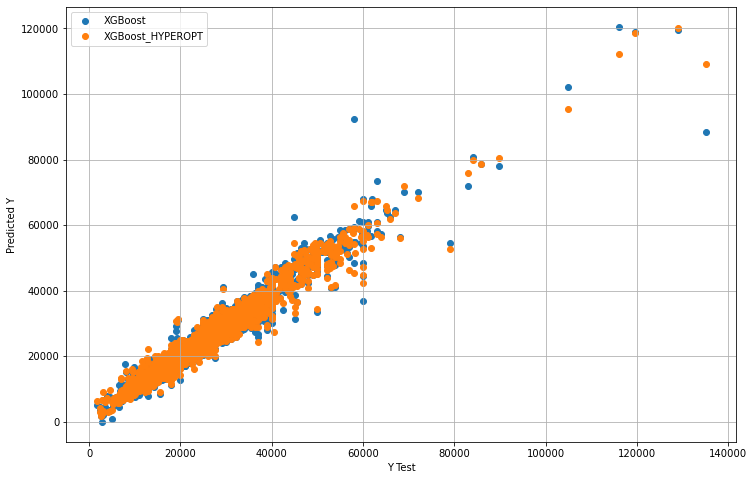

In [322]:
plt.figure(figsize = (12,8))

#plt.scatter(y_test, y_pred_SVM, label='SVM')
plt.scatter(y_test, y_pred_xgb, label='XGBoost')
plt.scatter(y_test, y_pred_XGB_OPT, label='XGBoost_HYPEROPT')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.legend(loc='upper left');
plt.grid()

In [323]:
mse_XGB_OPT = mean_squared_error(y_test, y_pred_XGB_OPT)
#print("RMSE using SVM: ", np.sqrt(mse_SVM))
print("RMSE using XGBoost: ", np.sqrt(MSE(y_pred_xgb,y_test)))
print("RMSE using XGBoost_HYPEROPT: ", np.sqrt(mse_XGB_OPT))

RMSE using XGBoost:  2503.31281287268
RMSE using XGBoost_HYPEROPT:  2330.2315117190237


We get better results with XGBoost and we can even improve the RMSE with the Baesian optimization

In [325]:
pickle.dump(xgb_opt, open('model.pkl','wb'))

# DEBUG FOR ML DEPLOYMENT

In [326]:
df.head()

,model,year,transmission,fuelType,mileage,tax,mpg,engineSize,price
0,A1,2017,Manual,Petrol,15735,150,55.4,1.4,12500
1,A6,2016,Automatic,Diesel,36203,20,64.2,2.0,16500
2,A1,2016,Manual,Petrol,29946,30,55.4,1.4,11000
3,A4,2017,Automatic,Diesel,25952,145,67.3,2.0,16800
4,A3,2019,Manual,Petrol,1998,145,49.6,1.0,17300


In [327]:
feat=['A1','2017','Manual','Petrol','15735','150','55.4','1.4']

In [328]:
num_feat = feat[4:8]
num_feat

['15735', '150', '55.4', '1.4']

In [329]:
df_cat=pd.DataFrame([feat[0:4]], columns=['model','year','transmission','fuelType'])
df_cat

,model,year,transmission,fuelType
0,A1,2017,Manual,Petrol


In [330]:
df_cat.year=int(df_cat.year)

In [331]:
cat_feat = enc.transform(df_cat).toarray()

In [332]:
enc_feat = np.append(num_feat, cat_feat)

In [333]:
scaled_feat=scaler.transform(enc_feat.reshape(1,-1))

In [334]:
scaled_feat.shape

(1, 57)

In [335]:
prediction = xgb_opt.predict(scaled_feat)[0]
prediction

12268.635